In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import typing
import random
import matplotlib.pyplot as plt


In [45]:
print(torch.cuda.is_available())

True


In [46]:
def model_validation(model, dataloader_train, dataloader_val, dataloader_test):
    """
    Computes the loss/accuracy of the model on the validation set.
    """
    loss_criterion = torch.nn.CrossEntropyLoss()
    dataloader_train, dataloader_val, dataloader_test = dataloaders
    
    tain_loss,train_acc =compute_loss_and_accuracy(dataloader_train,model,loss_criterion)
    val_loss,val_acc =compute_loss_and_accuracy(dataloader_val,model,loss_criterion)
    test_loss,test_acc =compute_loss_and_accuracy(dataloader_test,model,loss_criterion)
    print("Training set: Average loss: {:.4f}, Accuracy: {:.4f}".format(tain_loss,train_acc))
    print("Validation set: Average loss: {:.4f}, Accuracy: {:.4f}".format(val_loss,val_acc))
    print("Test set: Average loss: {:.4f}, Accuracy: {:.4f}".format(test_loss,test_acc))
    

    ob = {"train": [tain_loss,train_acc],
          "val": [val_loss,val_acc],
          "test":[test_loss,test_acc]   
    }
    return ob

In [47]:
torch.backends.cudnn.benchmark = True

# Cudnn is not deterministic by default. Set this to True if you want
# to be sure to reproduce your results
torch.backends.cudnn.deterministic = True

In [48]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

In [49]:
def validation_step(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.validation_history["loss"][self.global_step] = validation_loss
        self.validation_history["accuracy"][self.global_step] = validation_acc
        used_time = time.time() - self.start_time
        print(
            f"Epoch: {self.epoch:>1}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            f"Validation Loss: {validation_loss:.2f}",
            f"Validation Accuracy: {validation_acc:.3f}",
            sep=", ")
        self.model.train()

In [50]:
from torch.utils.data.sampler import SubsetRandomSampler

mean = (0.5, 0.5, 0.5)
std = (.25, .25, .25)




def load_aug(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        
        
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        
    ])
  
    data_train = torchvision.datasets.CIFAR10(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = torchvision.datasets.CIFAR10(root='./data',
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test

In [51]:


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])
device = "cuda:0" if torch.cuda.is_available() else "cpu"
kwargs = {} if device=='cpu' else {'num_workers': 1, 'pin_memory': True}
batch_size=4







classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self,image_channels,
                 num_classes):
        super().__init__()
        num_filters = 32  # Set number of filters in first conv layer
        self.num_classes = num_classes
        self.feature_extractor = nn.Sequential(
        #Layer 1
        nn.Conv2d(in_channels=3, out_channels=num_filters, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(),
        

        #Layer 2
        nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=[2,2], stride=2),
        nn.Dropout2d(p=0.2),

        # Layer 3
        nn.Conv2d(in_channels=num_filters*2, out_channels=num_filters*3, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_filters*3),
        nn.ReLU(),

        #Layer 4
        nn.Conv2d(in_channels=num_filters*3, out_channels=num_filters*4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=[2,2], stride=2),
        nn.Dropout2d(p=0.2),

        # Layer 5
        nn.Conv2d(in_channels=num_filters*4, out_channels=num_filters*5, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_filters*5),
        nn.ReLU(),
        #Layer 6
        nn.Conv2d(in_channels=num_filters*5, out_channels=num_filters*6, kernel_size=3, padding=1),
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=[2,2], stride=2),
        nn.Dropout2d(p=0.2),

        
        nn.Conv2d(in_channels=num_filters*6, out_channels=num_filters*7, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_filters*7),
        nn.ReLU(),
        #Layer 6
        nn.Conv2d(in_channels=num_filters*7, out_channels=num_filters*8, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=[2,2], stride=2),
        nn.Dropout2d(p=0.2)
        )
        self.num_output_features = 1024
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
        self.classifier = nn.Sequential(
           
           
            nn.Linear(self.num_output_features, 512),
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        
        return x




In [52]:
def to_cuda(elements):
    """
    Transfers every object in elements to GPU VRAM if available.
    elements can be a object or list/tuple of objects
    """
    if torch.cuda.is_available():
        if type(elements) == tuple or type(elements) == list:
            return [x.cuda() for x in elements]
        return elements.cuda()
    return elements

In [53]:
import torch
import typing
import time
import collections

import pathlib


def compute_loss_and_accuracy(
        dataloader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        
        loss_criterion: torch.nn.modules.loss._Loss):
    """
    Computes the average loss and the accuracy over the whole dataset
    in dataloader.
    Args:
        dataloder: Validation/Test dataloader
        model: torch.nn.Module
        loss_criterion: The loss criterion, e.g: torch.nn.CrossEntropyLoss()
    Returns:
        [average_loss, accuracy]: both scalar.
    """
    average_loss = 0
    accuracy = 0
    counter = 0
    # TODO: Implement this function (Task  2a)
    with torch.no_grad():
        for (X_batch, Y_batch) in dataloader:
            counter += 1
            # Transfer images/labels to GPU VRAM, if possible
            X_batch = to_cuda(X_batch)
            Y_batch = to_cuda(Y_batch)
            # Forward pass the images through our model
            output_probs = model(X_batch)

            # Compute Loss
            loss = loss_criterion(output_probs, Y_batch)
            average_loss += loss.item()
            #compute accuracy
            _, predicted = torch.max(output_probs.data, 1)
            total = Y_batch.size(0)
            correct = torch.sum(predicted == Y_batch).item()
            accuracy += correct / total
            
           
            
    average_loss /= len(dataloader)
    accuracy /= len(dataloader)
   
            
            

    return average_loss, accuracy


class Trainer:

    def __init__(self,
               
                 batch_size: int,
                 learning_rate: float,
                 early_stop_count: int,
                 epochs: int,
                 model: torch.nn.Module,
                 dataloaders: typing.List[torch.utils.data.DataLoader],
                 adam:bool=False,
                 d_lr:bool =True
                 ):
        """
            Initialize our trainer class.
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.early_stop_count = early_stop_count
        self.epochs = epochs
        self.adam = adam
        self.d_lr = d_lr

        # Since we are doing multi-class classification, we use CrossEntropyLoss
        self.loss_criterion = torch.nn.CrossEntropyLoss()
        # Initialize the model
        self.model = model
        # Transfer model to GPU VRAM, if possible.
        self.model = to_cuda(self.model)
        print(self.model)

        self.change_lr = 0
        
        if self.adam:
            self.optimizer = torch.optim.Adam(self.model.parameters(),
                                         self.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
            if d_lr:
                self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9, verbose=True)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         self.learning_rate)
        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = dataloaders

        # Validate our model everytime we pass through 50% of the dataset
        self.num_steps_per_val = len(self.dataloader_train) // 2
        self.global_step = 0
        self.start_time = time.time()

        # Tracking variables
        self.train_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()

        )
        self.validation_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.checkpoint_dir = pathlib.Path("checkpoints")

    def validation_step(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.validation_history["loss"][self.global_step] = validation_loss
        self.validation_history["accuracy"][self.global_step] = validation_acc
        used_time = time.time() - self.start_time
        print(
            f"Epoch: {self.epoch:>1}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            f"Validation Loss: {validation_loss:.2f}",
            f"Validation Accuracy: {validation_acc:.3f}",
            sep=", ")
        self.model.train()

    def should_early_stop(self):
        """
            Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        val_loss = self.validation_history["loss"]
        if len(val_loss) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = list(val_loss.values())[-self.early_stop_count:]
        first_loss = relevant_loss[0]
        if first_loss == min(relevant_loss):
            print("Early stop criteria met")
            return True
        return False

    def train_step(self, X_batch, Y_batch):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
        # Y_batch is the CIFAR10 image label. Shape: [batch_size]
        # Transfer images / labels to GPU VRAM, if possible
        X_batch = to_cuda(X_batch)
        Y_batch = to_cuda(Y_batch)

        # Perform the forward pass
        predictions = self.model(X_batch)
        # Compute the cross entropy loss for the batch
        loss = self.loss_criterion(predictions, Y_batch)
        # Backpropagation
        loss.backward()
        # Gradient descent step
        self.optimizer.step()
        # Reset all computed gradients to 0
        self.optimizer.zero_grad()
        
        return loss.detach().cpu().item()

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        def should_validate_model():
            return self.global_step % self.num_steps_per_val == 0

        for epoch in range(self.epochs):
            self.epoch = epoch
            # Perform a full pass through all the training samples
            for X_batch, Y_batch in self.dataloader_train:
                loss = self.train_step(X_batch, Y_batch)
                self.train_history["loss"][self.global_step] = loss
                self.global_step += 1
                # Compute loss/accuracy for validation set
                if should_validate_model():
                    self.validation_step()
                    #self.save_model()
                    if self.should_early_stop():
                        if self.adam and self.d_lr and self.change_lr == 0:
                          self.scheduler.step()
                          self.change_lr = 1
                          
                        else:
                          print("Early stopping.")
                          return

                    elif self.change_lr == 1:
                      self.change_lr =0    
    

    


In [54]:
from torchsummary import summary
epochs = 30
batch_size = 64
learning_rate = 0.0005# Should be 5e-5 for LeNet
early_stop_count = 4
dataloaders = load_aug(batch_size)
model_1 = Net(image_channels=3, num_classes=10)
trainer_ADAM = Trainer(
      batch_size,
      learning_rate,
      early_stop_count,
      epochs,
      model_1,
      dataloaders,
      adam=True,
      d_lr = True
)
summary(model_1,input_size=(3, 32, 32))
trainer_ADAM.train()



Files already downloaded and verified
Files already downloaded and verified
Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.2, i

In [55]:
dataloader_train, dataloader_val, dataloader_test = dataloaders

model_1.eval()
  
model_validation(model_1, dataloader_train, dataloader_val, dataloader_test)

Training set: Average loss: 0.3132, Accuracy: 0.8922
Validation set: Average loss: 0.6261, Accuracy: 0.7989
Test set: Average loss: 0.4586, Accuracy: 0.8583


{'test': [0.45856725965525696, 0.85828025477707],
 'train': [0.3132320415668433, 0.8922252844950214],
 'val': [0.6260706639931172, 0.7988528481012658]}

In [56]:
def plot_loss(loss_dict: dict, label: str = None, npoints_to_average=1, plot_variance=True):
    """
    Args:
        loss_dict: a dictionary where keys are the global step and values are the given loss / accuracy
        label: a string to use as label in plot legend
        npoints_to_average: Number of points to average plot
    """
    global_steps = list(loss_dict.keys())
    loss = list(loss_dict.values())
    if npoints_to_average == 1 or not plot_variance:
        plt.plot(global_steps, loss, label=label)
        return

    npoints_to_average = 10
    num_points = len(loss) // npoints_to_average
    mean_loss = []
    loss_std = []
    steps = []
    for i in range(num_points):
        points = loss[i*npoints_to_average:(i+1)*npoints_to_average]
        step = global_steps[i*npoints_to_average + npoints_to_average//2]
        mean_loss.append(np.mean(points))
        loss_std.append(np.std(points))
        steps.append(step)
    plt.plot(steps, mean_loss,
             label=f"{label} (mean over {npoints_to_average} steps)")
    plt.fill_between(
        steps, np.array(mean_loss) -
        np.array(loss_std), np.array(mean_loss) + loss_std,
        alpha=.2, label=f"{label} variance over {npoints_to_average} steps")

In [57]:
def create_plots(trainer: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    plot_loss(trainer.train_history["loss"], label="Training loss", npoints_to_average=10)
    plot_loss(trainer.validation_history["loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()

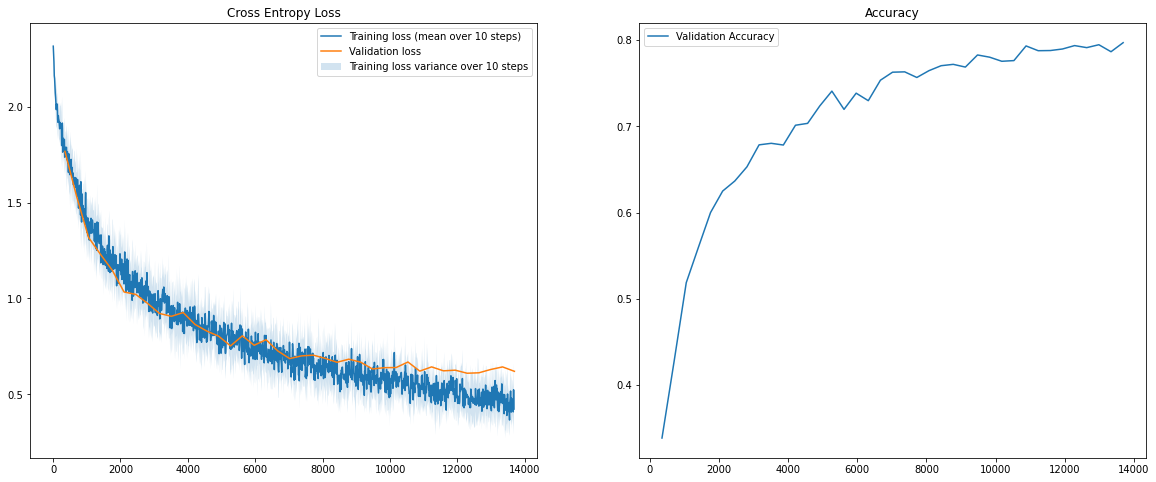

In [58]:
create_plots(trainer_ADAM,"task2")

In [59]:
from sklearn.metrics import PrecisionRecallDisplay

In [60]:
TP = 0
y_score = []
y_test =[]
accuracy = 0

with torch.no_grad():
        for (X_batch, Y_batch) in dataloader_test:
            
            # Transfer images/labels to GPU VRAM, if possible
            X_batch = to_cuda(X_batch)
            Y_batch = to_cuda(Y_batch)
            # Forward pass the images through our model
            outputs =model_1(X_batch)
           
            for i in outputs.cpu().detach().numpy():
                y_score.append(i.tolist())
        
            for j in Y_batch.cpu().detach().numpy():
              test = [0]*10
              test[j]=1
              
              
              y_test.append(test)
            
           

In [61]:
from sklearn.metrics import precision_recall_curve, auc
y_score = np.array(y_score)
y_test = np.array(y_test)

In [62]:
precision = dict()
recall = dict()
for i in range(10):
 
  precision[i], recall[i], _ = precision_recall_curve(y_test[:,i], y_score[:, i])

class:plane 0.8420414622650635
class:car 0.9416493063265947
class:bird 0.7915094478960596
class:cat 0.6351786893606136
class:deer 0.8370089285098647
class:dog 0.7276403398892068
class:frog 0.9408689706412354
class:horse 0.9374867527455046
class:ship 0.9447365221477007
class:truck 0.8049923115846541


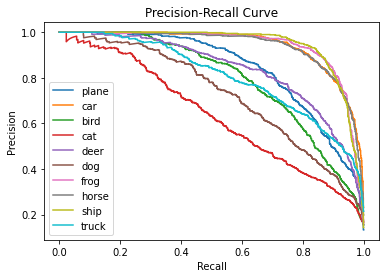

In [63]:
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
fig, ax = plt.subplots()
for i in range(10):
  ax.plot(recall[i], precision[i],label = classes[i])
  print(f'class:{classes[i]}',auc(recall[i], precision[i]))


#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend()

#display plot